# SQLiteのテスト その1

軌道要素データをSQLiteのデータベースに格納するテスト。

軌道要素データは既に spacetracktest3-gp.ipynb でダウンロード済みであるものとする。

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import json
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import sqlite3
dbfile1 = 'db/dbtest1.sqlite3'

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# column名
columns = ['CCSDS_OMM_VERS', 'COMMENT', 'CREATION_DATE', 'ORIGINATOR',
       'OBJECT_NAME', 'OBJECT_ID', 'CENTER_NAME', 'REF_FRAME',
       'TIME_SYSTEM', 'MEAN_ELEMENT_THEORY', 'EPOCH', 'MEAN_MOTION',
       'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'EPHEMERIS_TYPE',
       'CLASSIFICATION_TYPE', 'NORAD_CAT_ID', 'ELEMENT_SET_NO',
       'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT',
       'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS', 'OBJECT_TYPE',
       'RCS_SIZE', 'COUNTRY_CODE', 'LAUNCH_DATE', 'SITE', 'DECAY_DATE',
       'FILE', 'GP_ID', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2']
# 保存するcolumn
columns_out = ['CREATION_DATE', 'EPOCH', 'OBJECT_ID', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
    'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'NORAD_CAT_ID', 'REV_AT_EPOCH', 'BSTAR', 'SEMIMAJOR_AXIS',
    'PERIOD', 'APOAPSIS', 'PERIAPSIS', 'GP_ID', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2']

In [4]:
# 各columnの型
# https://www.space-track.org/basicspacedata/modeldef/class/gp/format/html も参照のこと
# decimal型のcolumnはfloat64として取り扱うことにする
# 型として str を指定すると、元データが null のとき、"None" という文字列になってしまうので、object を指定する
# 実際の元データでnullとなっているものがあるのは COUNTRY_CODE, DECAY_DATE, LAUNCH_DATE, OBJECT_ID, RCS_SIZE, SITE
dtype = {'CCSDS_OMM_VERS': object,  'COMMENT': object,  'CREATION_DATE': 'datetime64[ns]',  'ORIGINATOR': object, 
       'OBJECT_NAME': object,  'OBJECT_ID': object,  'CENTER_NAME': object,  'REF_FRAME': object, 
       'TIME_SYSTEM': object,  'MEAN_ELEMENT_THEORY': object,  'EPOCH': 'datetime64[ns]',  'MEAN_MOTION': 'float64', 
       'ECCENTRICITY': 'float64',  'INCLINATION': 'float64',  'RA_OF_ASC_NODE': 'float64', 
       'ARG_OF_PERICENTER': 'float64',  'MEAN_ANOMALY': 'float64',  'EPHEMERIS_TYPE': 'int8', 
       'CLASSIFICATION_TYPE': object,  'NORAD_CAT_ID': 'uint32',  'ELEMENT_SET_NO': 'uint16', 
       'REV_AT_EPOCH': 'uint32',  'BSTAR': 'float64',  'MEAN_MOTION_DOT': 'float64',  'MEAN_MOTION_DDOT': 'float64', 
       'SEMIMAJOR_AXIS': 'float64',  'PERIOD': 'float64',  'APOAPSIS': 'float64',  'PERIAPSIS': 'float64',  'OBJECT_TYPE': object, 
       'RCS_SIZE': object,  'COUNTRY_CODE': object,  'LAUNCH_DATE': 'datetime64[ns]',  'SITE': object,  'DECAY_DATE': 'datetime64[ns]', 
       'FILE': 'uint64',  'GP_ID': 'uint32',  'TLE_LINE0': object,  'TLE_LINE1': object,  'TLE_LINE2': object}

# 以下のcolumnは日時として解釈する (元データが空欄の場合は NaT になる)
convert_dates = ['EPOCH', 'CREATION_DATE', 'LAUNCH_DATE', 'DECAY_DATE']

In [5]:
# 既にダウンロード済みのデータを用いる (spacetracktest3-gp.ipynb でダウンロード)
norad_cat_id = 29479
file = 'download/gp_history_{}_all.json'.format(norad_cat_id)
df = pd.read_json(file, dtype = dtype, convert_dates = convert_dates, precise_float = True)

In [6]:
df.head(3)

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 18:03:07,18 SPCS,TBA - TO BE ASSIGNED,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-22 22:35:39.747263,15.302105,0.029731,98.3083,274.0769,131.1804,231.6053,0,U,29479,999,0,0.000000,-0.000007,0.000002,6853.324,94.104,678.947,271.432,TBA,None,None,NaT,None,NaT,311559,58833614,0 TBA - TO BE ASSIGNED,1 29479U 06041A 06265.94143226 -.00000724 22906-5 00000+0 0 9999,2 29479 098.3083 274.0769 0297312 131.1804 231.6053 15.30210541 03
1,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 20:05:18,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 00:09:44.819999,15.315795,0.028316,98.3158,274.1513,130.1928,232.3173,0,U,29479,999,0,0.094972,0.092218,0.055074,6849.240,94.020,665.049,277.161,TBA,None,JPN,2006-09-22,NULL,NaT,311562,58833618,0 OBJECT A,1 29479U 06041A 06266.00676875 .09221790 55074-1 94972-1 0 9995,2 29479 098.3158 274.1513 0283162 130.1928 232.3173 15.31579544 01
2,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 23:59:43,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 04:52:24.892896,15.279977,0.029644,98.3280,274.3622,129.3552,233.4332,0,U,29479,999,4,-0.070448,-0.076811,0.009903,6859.940,94.240,685.161,278.448,TBA,None,JPN,2006-09-22,NULL,NaT,311567,58833623,0 OBJECT A,1 29479U 06041A 06266.20306589 -.07681137 99032-2 -70448-1 0 9999,2 29479 098.3280 274.3622 0296440 129.3552 233.4332 15.27997695 45


In [7]:
# 重複するデータ
df[df.duplicated(subset=['EPOCH', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY'])]

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
907,2.0,GENERATED VIA SPACE-TRACK.ORG API,2008-02-04 09:10:28,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2008-02-03 22:38:31.801631,14.628066,0.001566,98.0807,43.7624,161.6091,198.5681,0,U,29479,999,7299,0.000035,1.300000e-06,0.0,7062.267,98.440,695.191,673.073,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,508105,64959489,0 HINODE (SOLAR B),1 29479U 06041A 08034.94342363 +.00000130 +00000-0 +34536-4 0 9990,2 29479 098.0807 043.7624 0015659 161.6091 198.5681 14.62806581072997
2435,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-06-25 09:00:21,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-06-24 21:17:25.093536,14.629933,0.001458,98.0891,178.1342,307.9843,52.0043,0,U,29479,999,20047,0.000020,5.400000e-07,0.0,7061.666,98.428,693.824,673.238,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,918281,78369796,0 HINODE (SOLAR B),1 29479U 06041A 10175.88709599 +.00000054 +00000-0 +19686-4 0 9994,2 29479 098.0891 178.1342 0014576 307.9843 052.0043 14.62993344200473
2469,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-07-19 10:34:41,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-07-16 11:59:16.490688,14.629986,0.001452,98.0902,199.3339,234.5399,125.4457,0,U,29479,999,20363,0.000017,3.800000e-07,0.0,7061.649,98.427,693.766,673.263,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,930798,78704525,0 HINODE (SOLAR B),1 29479U 06041A 10197.49949642 +.00000038 +00000-0 +16626-4 0 9993,2 29479 098.0902 199.3339 0014517 234.5399 125.4457 14.62998598203634
2621,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-10-18 08:13:32,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-10-17 22:10:53.989535,14.630272,0.001477,98.0955,291.0071,306.4023,53.5818,0,U,29479,999,21729,0.000045,1.850000e-06,0.0,7061.557,98.426,693.854,672.990,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,979656,80031909,0 HINODE (SOLAR B),1 29479U 06041A 10290.92423599 +.00000185 +00000-0 +45322-4 0 9991,2 29479 098.0955 291.0071 0014773 306.4023 053.5818 14.63027179217290
2771,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-01-24 08:13:19,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2011-01-23 22:18:01.917504,14.630596,0.001549,98.0973,27.1828,359.4483,0.6707,0,U,29479,999,23162,0.000023,7.300000e-07,0.0,7061.453,98.423,694.258,672.378,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1029686,81437321,0 HINODE (SOLAR B),1 29479U 06041A 11023.92918886 +.00000073 +00000-0 +23483-4 0 9994,2 29479 098.0973 027.1828 0015492 359.4483 000.6707 14.63059648231624
2786,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-02-02 07:47:32,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2011-02-01 21:19:13.414943,14.630619,0.001521,98.0977,35.9779,331.0580,28.9766,0,U,29479,999,23293,0.000030,1.090000e-06,0.0,7061.446,98.423,694.054,672.567,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1033744,81568004,0 HINODE (SOLAR B),1 29479U 06041A 11032.88834971 +.00000109 +00000-0 +30421-4 0 9991,2 29479 098.0977 035.9779 0015214 331.0580 028.9766 14.63061871232930
2788,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-02-03 07:49:16,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2011-02-02 21:56:27.508991,14.630622,0.001514,98.0981,36.9850,327.6581,32.3698,0,U,29479,999,23308,0.000030,1.050000e-06,0.0,7061.445,98.423,694.000,672.619,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,1034244,81583158,0 HINODE (SOLAR B),1 29479U 06041A 11033.91420728 +.00000105 +00000-0 +29696-4 0 9995,2 29479 098.0981 036.9850 0015139 327.6581 032.3698 14.63062194233083
2848,2.0,GENERATED VIA SPACE-TRACK.ORG API,2011-03-11 08:03:43,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,20

In [8]:
df[906:908]

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
906,2.0,GENERATED VIA SPACE-TRACK.ORG API,2008-02-03 18:28:18,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2008-02-03 22:38:31.801631,14.628066,0.001566,98.0807,43.7624,161.6091,198.5681,0,U,29479,999,7299,0.000035,0.000001,0.0,7062.267,98.44,695.191,673.073,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,507763,64948734,0 HINODE (SOLAR B),1 29479U 06041A 08034.94342363 .00000130 00000-0 34536-4 0 9990,2 29479 098.0807 043.7624 0015659 161.6091 198.5681 14.62806581 72997
907,2.0,GENERATED VIA SPACE-TRACK.ORG API,2008-02-04 09:10:28,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2008-02-03 22:38:31.801631,14.628066,0.001566,98.0807,43.7624,161.6091,198.5681,0,U,29479,999,7299,0.000035,0.000001,0.0,7062.267,98.44,695.191,673.073,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,508105,64959489,0 HINODE (SOLAR B),1 29479U 06041A 08034.94342363 +.00000130 +00000-0 +34536-4 0 9990,2 29479 098.0807 043.7624 0015659 161.6091 198.5681 14.62806581072997


In [9]:
# DBを作成
conn = sqlite3.connect(dbfile1)
c = conn.cursor()

In [10]:
#c.execute('''CREATE TABLE IF NOT EXISTS elset (
#    CREATION_DATE timestamp, EPOCH timestamp, OBJECT_ID text,
#    MEAN_MOTION real, ECCENTRICITY real, INCLINATION real, RA_OF_ASC_NODE real, ARG_OF_PERICENTER real, MEAN_ANOMALY real,
#    NORAD_CAT_ID integer, REV_AT_EPOCH integer, BSTAR real, SEMIMAJOR_AXIS real, PERIOD real, APOAPSIS real, PERIAPSIS real,
#    GP_ID integer, TLE_LINE0 text, TLE_LINE1 text, TLE_LINE2 text)''')

In [11]:
df[columns_out].to_sql('elset', conn, if_exists='replace', index=None)

In [12]:
# Index作成
c.execute('''CREATE INDEX IF NOT EXISTS elset_index ON elset (CREATION_DATE, EPOCH, GP_ID)''')

In [13]:
conn.commit()

In [14]:
conn.close()

In [15]:
with sqlite3.connect(dbfile1) as conn:
    c = conn.cursor()
    c.execute("select * from sqlite_master where type='table' and name='elset'")
    print(c.fetchone())

('table', 'elset', 'elset', 2, 'CREATE TABLE "elset" (\n"CREATION_DATE" TIMESTAMP,\n  "EPOCH" TIMESTAMP,\n  "OBJECT_ID" TEXT,\n  "MEAN_MOTION" REAL,\n  "ECCENTRICITY" REAL,\n  "INCLINATION" REAL,\n  "RA_OF_ASC_NODE" REAL,\n  "ARG_OF_PERICENTER" REAL,\n  "MEAN_ANOMALY" REAL,\n  "NORAD_CAT_ID" INTEGER,\n  "REV_AT_EPOCH" INTEGER,\n  "BSTAR" REAL,\n  "SEMIMAJOR_AXIS" REAL,\n  "PERIOD" REAL,\n  "APOAPSIS" REAL,\n  "PERIAPSIS" REAL,\n  "GP_ID" INTEGER,\n  "TLE_LINE0" TEXT,\n  "TLE_LINE1" TEXT,\n  "TLE_LINE2" TEXT\n)')


In [16]:
# DBから読み込み
with sqlite3.connect(dbfile1) as conn:
    df_in = pd.read_sql_query("SELECT * FROM elset", conn, parse_dates = ['CREATION_DATE', 'EPOCH'])
df_in.head()

,CREATION_DATE,EPOCH,OBJECT_ID,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2006-09-22 18:03:07,2006-09-22 22:35:39.747263,2006-041A,15.302105,0.029731,98.3083,274.0769,131.1804,231.6053,29479,0,0.000000,6853.324,94.104,678.947,271.432,58833614,0 TBA - TO BE ASSIGNED,1 29479U 06041A 06265.94143226 -.00000724 22906-5 00000+0 0 9999,2 29479 098.3083 274.0769 0297312 131.1804 231.6053 15.30210541 03
1,2006-09-22 20:05:18,2006-09-23 00:09:44.819999,2006-041A,15.315795,0.028316,98.3158,274.1513,130.1928,232.3173,29479,0,0.094972,6849.240,94.020,665.049,277.161,58833618,0 OBJECT A,1 29479U 06041A 06266.00676875 .09221790 55074-1 94972-1 0 9995,2 29479 098.3158 274.1513 0283162 130.1928 232.3173 15.31579544 01
2,2006-09-22 23:59:43,2006-09-23 04:52:24.892896,2006-041A,15.279977,0.029644,98.3280,274.3622,129.3552,233.4332,29479,4,-0.070448,6859.940,94.240,685.161,278.448,58833623,0 OBJECT A,1 29479U 06041A 06266.20306589 -.07681137 99032-2 -70448-1 0 9999,2 29479 098.3280 274.3622 0296440 129.3552 233.4332 15.27997695 45
3,2006-09-23 01:22:45,2006-09-23 04:52:24.932639,2006-041A,15.280796,0.029644,98.3280,274.3622,129.3552,233.4314,29479,4,-0.066173,6859.694,94.235,684.908,278.211,58835318,0 OBJECT A,1 29479U 06041A 06266.20306635 -.07204601 85499-2 -66173-1 0 9990,2 29479 098.3280 274.3622 0296440 129.3552 233.4314 15.28079605 48
4,2006-09-23 04:57:19,2006-09-23 09:35:01.257504,2006-041A,15.297827,0.028664,98.3271,274.6004,128.2523,234.4722,29479,7,0.000441,6854.602,94.131,672.951,279.983,58835332,0 OBJECT A,1 29479U 06041A 06266.39932011 .00046819 27651-5 44140-3 0 9990,2 29479 098.3271 274.6004 0286645 128.2523 234.4722 15.29782742 78


In [17]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8488 entries, 0 to 8487
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CREATION_DATE      8488 non-null   datetime64[ns]
 1   EPOCH              8488 non-null   datetime64[ns]
 2   OBJECT_ID          8488 non-null   object        
 3   MEAN_MOTION        8488 non-null   float64       
 4   ECCENTRICITY       8488 non-null   float64       
 5   INCLINATION        8488 non-null   float64       
 6   RA_OF_ASC_NODE     8488 non-null   float64       
 7   ARG_OF_PERICENTER  8488 non-null   float64       
 8   MEAN_ANOMALY       8488 non-null   float64       
 9   NORAD_CAT_ID       8488 non-null   int64         
 10  REV_AT_EPOCH       8488 non-null   int64         
 11  BSTAR              8488 non-null   float64       
 12  SEMIMAJOR_AXIS     8488 non-null   float64       
 13  PERIOD             8488 non-null   float64       
 14  APOAPSIS

In [18]:
# EPOCHはマイクロ秒まで保存しているので、datetime関数を使えない
with sqlite3.connect(dbfile1) as conn:
    df_in = pd.read_sql_query("SELECT * FROM elset WHERE EPOCH BETWEEN '2010-01-01 00:00:00.000000' AND '2010-01-03 00:00:00.000000'", 
                              conn, parse_dates = ['CREATION_DATE', 'EPOCH'])
df_in.head()

,CREATION_DATE,EPOCH,OBJECT_ID,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2010-01-02 12:48:57,2010-01-01 19:43:21.791999,2006-041A,14.629422,0.001632,98.0864,7.4417,129.7220,230.5408,29479,17502,0.000011,7061.831,98.431,695.220,672.172,75830974,0 HINODE (SOLAR B),1 29479U 06041A 10001.82178000 +.00000007 +00000-0 +10573-4 0 9997,2 29479 098.0864 007.4417 0016319 129.7220 230.5408 14.62942188175026
1,2010-01-02 00:05:49,2010-01-02 02:17:19.576607,2006-041A,14.629423,0.001634,98.0865,7.7098,128.9909,231.2759,29479,17506,0.000011,7061.831,98.431,695.236,672.155,75822324,0 HINODE (SOLAR B),1 29479U 06041A 10002.09536547 .00000007 00000-0 10526-4 0 9999,2 29479 098.0865 007.7098 0016342 128.9909 231.2759 14.62942257175064
2,2010-01-03 13:01:52,2010-01-02 18:42:13.940927,2006-041A,14.629422,0.001636,98.0865,8.3800,126.8581,233.4112,29479,17516,0.000007,7061.831,98.431,695.246,672.145,75841639,0 HINODE (SOLAR B),1 29479U 06041A 10002.77932802 -.00000013 +00000-0 +66831-5 0 9997,2 29479 098.0865 008.3800 0016356 126.8581 233.4112 14.62942246175166


In [19]:
# 3日以内に作成されたデータ
with sqlite3.connect(dbfile1) as conn:
    df_in = pd.read_sql_query("SELECT * FROM elset WHERE CREATION_DATE > datetime('now', '-3 days')",
                              conn, parse_dates = ['CREATION_DATE', 'EPOCH'])
df_in

,CREATION_DATE,EPOCH,OBJECT_ID,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2020-11-20 14:46:09,2020-11-20 06:36:39.563424,2006-041A,14.651001,0.001606,98.1565,335.8351,236.0082,123.9596,29479,75671,0.000024,7054.891,98.286,688.084,665.428,165916785,0 HINODE (SOLAR B),1 29479U 06041A 20325.27545791 .00000081 00000-0 24121-4 0 9997,2 29479 98.1565 335.8351 0016057 236.0082 123.9596 14.65100089756710
1,2020-11-21 05:49:19,2020-11-20 18:05:04.711200,2006-041A,14.651002,0.001608,98.1565,336.3092,234.3931,125.5775,29479,75677,0.000025,7054.890,98.286,688.098,665.412,165960366,0 HINODE (SOLAR B),1 29479U 06041A 20325.75352675 +.00000085 +00000-0 +24827-4 0 9994,2 29479 098.1565 336.3092 0016078 234.3931 125.5775 14.65100204756777
2,2020-11-21 14:46:10,2020-11-21 07:11:50.596224,2006-041A,14.651004,0.001610,98.1565,336.8510,232.5902,127.3836,29479,75686,0.000026,7054.890,98.286,688.114,665.396,165988850,0 HINODE (SOLAR B),1 29479U 06041A 20326.29989116 .00000091 00000-0 25905-4 0 9995,2 29479 98.1565 336.8510 0016101 232.5902 127.3836 14.65100354756866
3,2020-11-21 18:30:46,2020-11-21 00:38:27.652416,2006-041A,14.651003,0.001609,98.1565,336.5801,233.4859,126.4862,29479,75681,0.000025,7054.890,98.286,688.108,665.402,166003568,0 HINODE (SOLAR B),1 29479U 06041A 20326.02670894 +.00000084 +00000-0 +24768-4 0 9994,2 29479 098.1565 336.5801 0016092 233.4859 126.4862 14.65100281756819
4,2020-11-22 03:58:10,2020-11-21 21:56:57.205536,2006-041A,14.651006,0.001613,98.1565,337.4606,230.5408,129.4368,29479,75694,0.000028,7054.889,98.286,688.134,665.374,166031834,0 HINODE (SOLAR B),1 29479U 06041A 20326.91455099 +.00000102 +00000-0 +27961-4 0 9999,2 29479 098.1565 337.4606 0016130 230.5408 129.4368 14.65100580756943
5,2020-11-22 16:41:21,2020-11-22 14:20:24.542592,2006-041A,14.651009,0.001616,98.1565,338.1379,228.2656,131.7166,29479,75704,0.000031,7054.888,98.286,688.154,665.352,166067842,0 HINODE (SOLAR B),1 29479U 06041A 20327.59750628 +.00000118 +00000-0 +30996-4 0 9999,2 29479 098.1565 338.1379 0016160 228.2656 131.7166 14.65100883757040
6,2020-11-22 22:26:11,2020-11-22 19:15:26.743968,2006-041A,14.651009,0.001617,98.1565,338.3411,227.5849,132.3986,29479,75708,0.000031,7054.888,98.286,688.161,665.344,166085306,0 HINODE (SOLAR B),1 29479U 06041A 20327.80239287 .00000118 00000-0 31058-4 0 9996,2 29479 98.1565 338.3411 0016171 227.5849 132.3986 14.65100926757086


In [20]:
# 日付ごとのEPOCHの件数
with sqlite3.connect(dbfile1) as conn:
    df_in = pd.read_sql_query("SELECT STRFTIME('%Y-%m-%d', EPOCH) AS DAY, DATE(EPOCH) AS EPOCH, COUNT(*) AS COUNT FROM elset GROUP BY DAY",
                              conn, parse_dates = ['CREATION_DATE', 'EPOCH'])
df_in

,DAY,EPOCH,COUNT
0,2006-09-22,2006-09-22,1
1,2006-09-23,2006-09-23,9
2,2006-09-24,2006-09-24,11
3,2006-09-25,2006-09-25,4
4,2006-09-26,2006-09-26,2
...,...,...,...
4948,2020-11-18,2020-11-18,3
4949,2020-11-19,2020-11-19,2
4950,2020-11-20,2020-11-20,2
4951,2020-11-21,2020-11-21,3


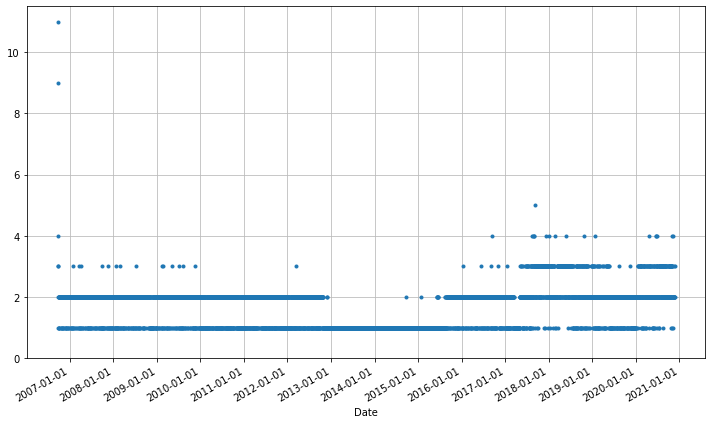

In [21]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df_in['EPOCH'], df_in['COUNT'], '.')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax1.set_ylim(bottom=0)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()